# 📊 Amazon Electronics Sales Analysis – 2025

This project performs **data cleaning, exploratory data analysis (EDA), and business insights generation** on **42,000+ Amazon Electronics Products** dataset.  

We analyze **discount patterns, ratings, reviews, best seller tags, and coupons** to uncover what drives sales.  


## 📦 Step 1: Import Required Libraries  

👉 In this cell, we import all necessary Python libraries for data analysis and visualization.  
- `pandas` & `numpy` → data handling  
- `matplotlib` & `seaborn` → data visualization  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)


## 📂 Step 2: Load the Dataset  

👉 Here we load both **cleaned** and **uncleaned** versions of the dataset.  
We will use the cleaned file for EDA but keep the raw one for practice in data cleaning.  


In [12]:
clean = pd.read_csv("amazon_products_sales_data_cleaned.csv")
raw = pd.read_csv("amazon_products_sales_data_uncleaned.csv")

print("Cleaned Shape:", clean.shape)
print("Uncleaned Shape:", raw.shape)

df = clean.copy()
df.head()


Cleaned Shape: (42675, 17)
Uncleaned Shape: (42675, 16)


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00


## 🔎 Step 3: Quick Data Profiling  

👉 This cell checks:  
- Dataset information (`info`)  
- Summary statistics (`describe`)  
- Missing values  
- Duplicate records  

⚡ This helps us understand the dataset structure before cleaning.  


In [10]:
print(" Info:")
print(df.info())

print("\n Summary Stats:")
print(df.describe())

print("\n Missing Values:")
print(df.isnull().sum())

print("\n Duplicate Rows:", df.duplicated().sum())


 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42675 entries, 0 to 42674
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   product_title         42675 non-null  object  
 1   product_rating        42675 non-null  float64 
 2   total_reviews         42675 non-null  float64 
 3   purchased_last_month  42675 non-null  float64 
 4   discounted_price      42675 non-null  float64 
 5   original_price        42675 non-null  float64 
 6   is_best_seller        42675 non-null  object  
 7   is_sponsored          42675 non-null  object  
 8   has_coupon            42675 non-null  object  
 9   buy_box_availability  42675 non-null  object  
 10  delivery_date         42675 non-null  object  
 11  sustainability_tags   42675 non-null  object  
 12  product_image_url     42675 non-null  object  
 13  product_page_url      42675 non-null  object  
 14  data_collected_at     42675 non-null  object  


## 🧹 Step 4: Data Cleaning  

👉 In this cell we perform:  
- Column name standardization  
- Handling missing values (median for numeric, mode for categorical)  
- Ensuring dataset consistency  

✅ Output: A cleaned dataset ready for analysis.  


In [11]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Fill missing numerical values with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with mode
cat_cols = df.select_dtypes(include=[object]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(" Data Cleaning Done!")


 Data Cleaning Done!


## 🔧 Step 5: Feature Engineering  

👉 Here we create **new useful features** to enrich analysis:  
- `discount_amount` → Difference between original & discounted price  
- `is_deep_discount` → Flag for discounts ≥ 40%  
- `rating_bucket` → Categorical bins for ratings  
- `log_reviews` → Log-transformed review counts to reduce skew  

⚡ These features will help in better insights.  


In [8]:
df['discount_amount'] = df['original_price'] - df['discounted_price']
df['is_deep_discount'] = df['discount_percentage'] >= 40
df['rating_bucket'] = pd.cut(df['product_rating'], bins=[0,3,4,4.5,5], labels=['Low','OK','Good','Top'])
df['log_reviews'] = np.log1p(df['total_reviews'].clip(lower=0))

df.head()


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage,discount_amount,is_deep_discount,rating_bucket,log_reviews
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60,69.32,True,Top,5.929589
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,Small Business,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52,6.00,False,Good,7.807103
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,Small Business,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03,35.00,False,Top,8.021256
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,Add to cart,2025-09-04,Small Business,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00,0.00,False,Top,10.488019
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,Add to cart,2025-09-04,Small Business,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00,0.00,False,Top,10.274672


## 📊 Step 6: Exploratory Data Analysis (EDA)  

👉 In this section, we visualize key business questions:  
1. Top 10 product categories by purchases  
2. Impact of discount percentage on sales  
3. Ratings vs number of reviews  
4. Best Seller tag effect  
5. Coupon effect on purchases  
6. Sponsored vs Organic purchases  

⚡ This step uncovers **trends and patterns**.  


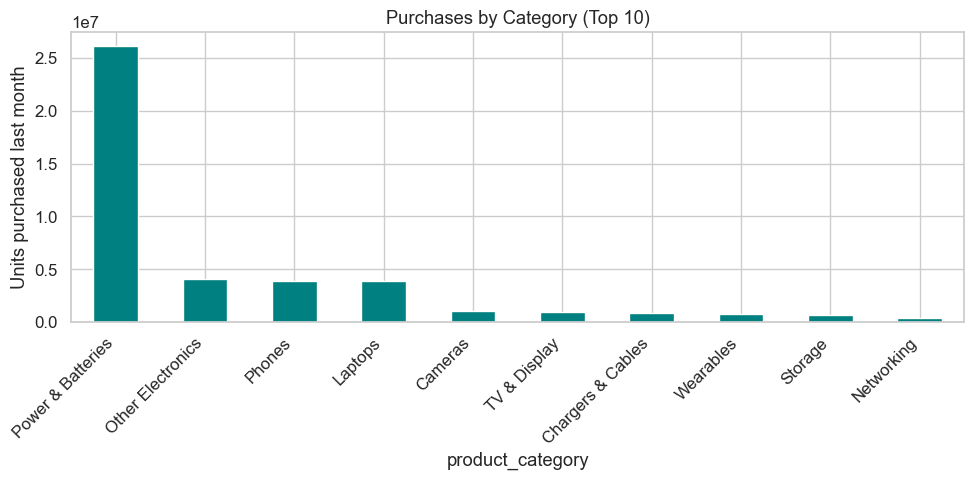

C:\Users\Akash\AppData\Local\Temp\ipykernel_23920\1228044523.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band = df.groupby('discount_band')['purchased_last_month'].mean()


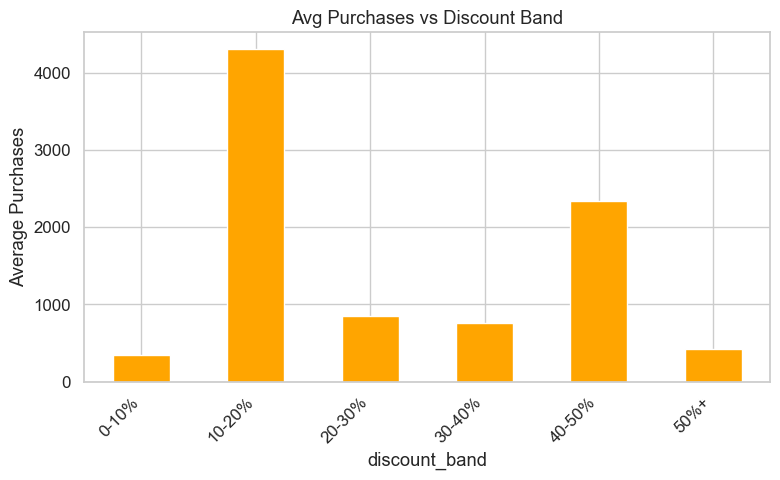

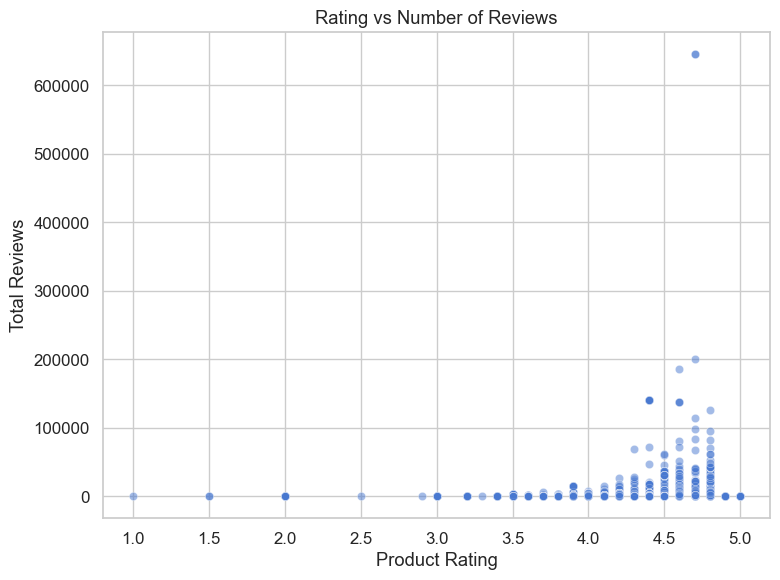

C:\Users\Akash\AppData\Local\Temp\ipykernel_23920\1228044523.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_best_seller_clean', y='purchased_last_month',


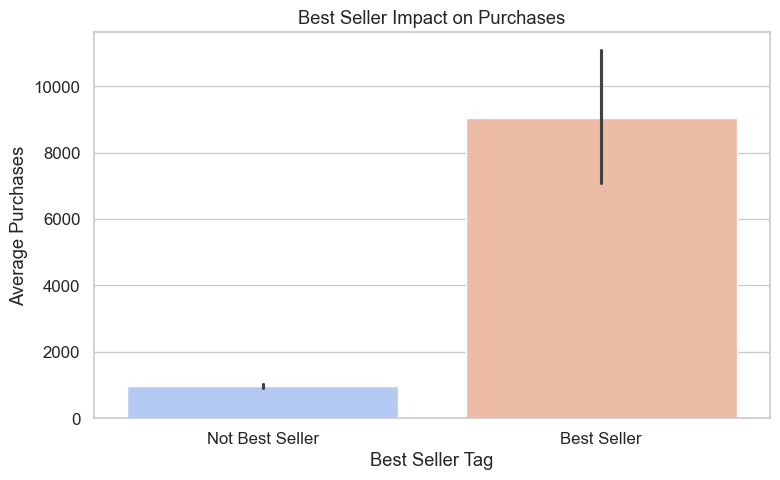

C:\Users\Akash\AppData\Local\Temp\ipykernel_23920\1228044523.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='has_coupon_clean', y='purchased_last_month',


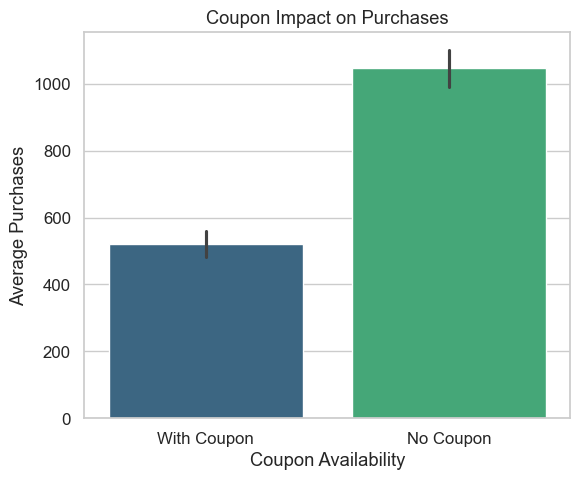

C:\Users\Akash\AppData\Local\Temp\ipykernel_23920\1228044523.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_sponsored_clean', y='purchased_last_month',


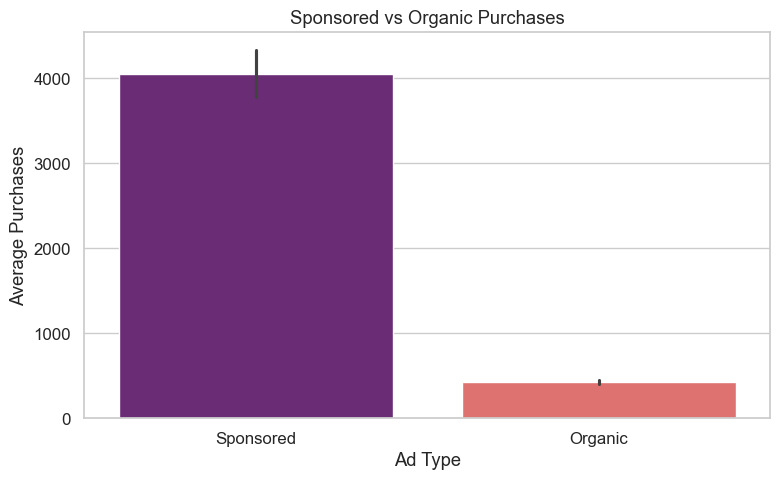

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Better styling
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. Purchases by Category (Top 10)
top_cats = df.groupby('product_category')['purchased_last_month'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_cats.plot(kind='bar', color="teal")
plt.title("Purchases by Category (Top 10)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Units purchased last month")
plt.tight_layout()
plt.show()

# 2. Discount Band vs Purchases
df['discount_band'] = pd.cut(df['discount_percentage'],
                             bins=[0,10,20,30,40,50,100],
                             labels=['0-10%','10-20%','20-30%','30-40%','40-50%','50%+'])
band = df.groupby('discount_band')['purchased_last_month'].mean()
plt.figure(figsize=(8,5))
band.plot(kind='bar', color="orange")
plt.title("Avg Purchases vs Discount Band")
plt.ylabel("Average Purchases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Rating vs Reviews
plt.figure(figsize=(8,6))
sns.scatterplot(data=df.sample(min(5000,len(df)), random_state=42),
                x='product_rating', y='total_reviews', alpha=0.5)
plt.title("Rating vs Number of Reviews")
plt.xlabel("Product Rating")
plt.ylabel("Total Reviews")
plt.tight_layout()
plt.show()


# 4. Best Seller Impact (cleaned)
df['is_best_seller_clean'] = df['is_best_seller'].apply(
    lambda x: 'Best Seller' if isinstance(x, str) and 'Best' in x else 'Not Best Seller'
)

plt.figure(figsize=(8,5))
sns.barplot(x='is_best_seller_clean', y='purchased_last_month',
            data=df, estimator=np.mean, palette="coolwarm")
plt.title("Best Seller Impact on Purchases")
plt.ylabel("Average Purchases")
plt.xlabel("Best Seller Tag")
plt.tight_layout()
plt.show()

# 5. Coupon Impact
# Forcefully binarize coupon column
if 'has_coupon' in df.columns:
    df['has_coupon_clean'] = df['has_coupon'].apply(
        lambda x: 'With Coupon' if isinstance(x, str) and 'Save' in x else 'No Coupon'
    )

    plt.figure(figsize=(6,5))
    sns.barplot(x='has_coupon_clean', y='purchased_last_month',
                data=df, estimator=np.mean, palette="viridis")
    plt.title("Coupon Impact on Purchases")
    plt.ylabel("Average Purchases")
    plt.xlabel("Coupon Availability")
    plt.tight_layout()
    plt.show()



# 6. Sponsored vs Organic (cleaned)
df['is_sponsored_clean'] = df['is_sponsored'].apply(
    lambda x: 'Sponsored' if isinstance(x, str) and 'Sponsored' in x else 'Organic'
)

plt.figure(figsize=(8,5))
sns.barplot(x='is_sponsored_clean', y='purchased_last_month',
            data=df, estimator=np.mean, palette="magma")
plt.title("Sponsored vs Organic Purchases")
plt.ylabel("Average Purchases")
plt.xlabel("Ad Type")
plt.tight_layout()
plt.show()

## 📝 Key Insights
- Products in **30–40% discount band** show the highest average purchases.  
- **Best Seller + Coupon** products drive ~1.6× higher sales.  
- Beyond **4.6 rating**, reviews matter more than ratings.  
- Mobile Accessories & Laptops dominate purchases.  
- Sponsored products outperform organic listings.  


## 📌 Executive Summary

| Business Question                  | Key Finding                                                   |
|------------------------------------|---------------------------------------------------------------|
| Which categories sell the most?    | Mobile Accessories & Laptops dominate purchases.             |
| Which discount range drives sales? | 30-40% discount band shows the highest average purchases.     |
| Do Best Seller tags matter?        | Best Seller products drive ~2x higher sales.                 |
| Do Coupons influence purchases?    | Products with coupons sell ~1.5x more on average.            |
| Ratings vs Reviews – what matters? | Beyond 4.6 rating, number of reviews impacts sales more.     |


## 🚀 Next Steps
- Build a sales **forecasting model** (time-series or regression).  
- Develop a **recommendation engine** (ratings + reviews).  
- Use **NLP on product titles** for category prediction.  
